# Import

In [34]:
import os
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from typing import Tuple, List

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [35]:
df = pd.read_csv("data/bilan-electrique.csv")

In [36]:
df.head()

,Unnamed: 0,datasetid,recordid,record_timestamp,injection_rte,pertes,consommation_hta,soutirage_rte,production_profilee_photovoltaique,temperature_normale_lissee,...,consommation_profilee,production_profilee_aut,consommation_totale,mois,consommation_profilee_ent_hta,pseudo_rayonnement,soutirage_vers_autres_grd,horodate,consommation_telerelevee,production_photovoltaique
0,0,bilan-electrique-demi-heure,469e9a182b7876ef60a589d1c5e96c7b126e3d5d,2023-05-23T01:00:01.072Z,3.227413e+10,2.247576e+09,1.002737e+10,1.638638e+09,4331.0,15.2,...,1.996788e+10,1724126.0,3.339388e+10,5,7527228.0,40,291466466.0,2023-05-12T21:30:00+00:00,1.342601e+10,524678.0
1,1,bilan-electrique-demi-heure,aea7a5ab2946b8ee22696513a55df582ab4cc88e,2023-05-23T01:00:01.072Z,3.267876e+10,2.269769e+09,1.014904e+10,1.774022e+09,4748.0,15.2,...,2.008523e+10,1724126.0,3.375851e+10,5,7761054.0,40,278342766.0,2023-05-12T21:00:00+00:00,1.367329e+10,583186.0
2,2,bilan-electrique-demi-heure,82a5950691826f564c0478fac263d680d13d9f52,2023-05-23T01:00:01.072Z,3.322081e+10,2.306844e+09,1.027547e+10,1.710208e+09,2858.0,15.3,...,2.033158e+10,1724126.0,3.426999e+10,5,7963496.0,37,273891883.0,2023-05-12T20:30:00+00:00,1.393841e+10,542160.0
3,3,bilan-electrique-demi-heure,4efcda9b8c74f09c20d2587aff2ba39fe2c631f5,2023-05-23T01:00:01.072Z,3.167001e+10,2.154198e+09,1.037604e+10,1.604080e+09,4413.0,15.4,...,1.861184e+10,1724126.0,3.279717e+10,5,8238396.0,35,243759584.0,2023-05-12T20:00:00+00:00,1.418533e+10,615659.0
4,4,bilan-electrique-demi-heure,623033632a70179a7876b3f6c4976e657b8b31de,2023-05-23T01:00:01.072Z,3.144377e+10,2.130123e+09,1.038117e+10,1.668876e+09,9740.0,15.6,...,1.836745e+10,1724126.0,3.253997e+10,5,7857570.0,32,248111450.0,2023-05-12T19:30:00+00:00,1.417252e+10,574664.0


In [37]:
df['horodate'] = pd.to_datetime(df['horodate']) # Convert 'horodate' column to datetime
df = df.set_index('horodate') # Set 'horodate' as the index
hourly_avg = df.groupby(pd.Grouper(freq='H'))['consommation_totale'].mean().reset_index(name='consommation_totale')

In [38]:
def read_data(data_path : str = "data/bilan-electrique.csv") -> pd.DataFrame:
    df = pd.read_csv(data_path)
    df['horodate'] = pd.to_datetime(df['horodate']) # Convert 'horodate' column to datetime
    df = df.set_index('horodate') # Set 'horodate' as the index
    hourly_avg = df.groupby(pd.Grouper(freq='H'))['consommation_totale'].mean().reset_index(name='consommation_totale')
    return hourly_avg

#print first date
print(hourly_avg['horodate'].iloc[0])

2022-10-16 14:00:00+00:00


## Create the model

The task is to predict a week (168 hours) of consumption. 2 approaches can be used with deep neural networks. We can either predict a single timestamp (next hour) with a given sequence and repeat the process with the predicted timestamp or directly predict the 168 hours from a given sequence with a sequence to sequence model. Predicting a single timestamp and then feeding the prediction back into the model for a week can be simpler in terms of model architecture, but it might lead to the propagation of errors. Since each prediction is used as input for the next prediction, errors can accumulate rapidly. This is especially true for long sequence predictions like a week (168 hours).On the other hand, directly predicting the next week's worth of data (sequence prediction) can potentially be more accurate since it can leverage information from all input at once. But the model architecture can be more complex, and the training might be more difficult and computationally expensive. Plus, it might overfit to specific sequences length and not generalize well to other lengths.

Here we have chosen to implement the simple model predicting only the next timestamp.

In [39]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
    
        # use the last hidden state as the input to the fully connected layer
        out = self.fc(hidden[-1])
    
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return hidden


## Prepare the data

In [40]:
def create_sequences(data, sequence_length, pred_len=1):
    x = []
    y = []
    for i in range(len(data)-sequence_length-pred_len+1):
        x.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+pred_len])
    return np.array(x), np.array(y)

In [41]:
from datetime import datetime
import time
from sklearn.model_selection import train_test_split

def preprocess_data(file_path, sequence_length=186, output_seq_len=1, split_ratio=0.8, batch_size=32):
    # Load the dataset
    df = read_data(file_path)
    data = df['consommation_totale'].values.reshape(-1, 1)
    
    # Normalize the 'consommation_totale' data with MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)
    
    x, y = create_sequences(data, sequence_length, output_seq_len)  # pass output_seq_len here
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-split_ratio, random_state=42)

    # Convert to Tensors and create data loaders
    train_data = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    test_data = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
    
    return train_loader, test_loader, scaler

## Train the model

In [42]:
import matplotlib.pyplot as plt
import tqdm

def train_model(model, train_loader, test_loader, num_epochs, learning_rate, patience=5):
    """Train the model and print the loss for each epoch

    Args:
        model: the model to train
        train_loader: the training data loader
        test_loader: the testing data loader
        num_epochs: the number of epochs to train
        learning_rate: the learning rate
        patience: the number of epochs to wait before early stopping
    """
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # clip gradients to prevent exploding gradient problem 
    criterion = torch.nn.MSELoss() # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer (backward pass)
    
    train_loss_list = []
    test_loss_list = []

    best_loss = float('inf')
    no_improve_epoch = 0

    for epoch in tqdm.tqdm(range(num_epochs), desc='Training the model', unit='epoch', total=num_epochs):
        
        ## Training
        train_loss = 0
        for inputs, targets in train_loader: # for each training step
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs) # forward pass
            targets = targets[:,0,:]
            loss = criterion(output, targets)

            optimizer.zero_grad() # clear the gradients
            loss.backward() # backward pass
            optimizer.step() # optimize the weights

            train_loss += loss.item() 
            
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
        
        ## Testing 
        test_loss = 0
        with torch.no_grad(): 
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                output = model(inputs)
                targets = targets[:,0,:]
                loss = criterion(output, targets)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_loss_list.append(test_loss)

        print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, test_loss))

        # check for early stopping (prevent overfitting)
        if test_loss < best_loss:
            best_loss = test_loss
            no_improve_epoch = 0
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                print('Early stopping')
                break

    # Plot training and testing loss
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(test_loss_list, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Time')
    plt.legend()
    plt.show()

    return model


Training the model:   1%|          | 1/100 [00:05<08:39,  5.25s/epoch]

Epoch [1/100], Loss: 0.1418, Test Loss: 0.1145


Training the model:   2%|▏         | 2/100 [00:10<08:30,  5.21s/epoch]

Epoch [2/100], Loss: 0.0760, Test Loss: 0.0333


Training the model:   3%|▎         | 3/100 [00:15<08:29,  5.26s/epoch]

Epoch [3/100], Loss: 0.0299, Test Loss: 0.0277


Training the model:   4%|▍         | 4/100 [00:21<08:27,  5.29s/epoch]

Epoch [4/100], Loss: 0.0283, Test Loss: 0.0263


Training the model:   5%|▌         | 5/100 [00:26<08:24,  5.31s/epoch]

Epoch [5/100], Loss: 0.0269, Test Loss: 0.0249


Training the model:   6%|▌         | 6/100 [00:31<08:19,  5.31s/epoch]

Epoch [6/100], Loss: 0.0254, Test Loss: 0.0234


Training the model:   7%|▋         | 7/100 [00:37<08:15,  5.33s/epoch]

Epoch [7/100], Loss: 0.0238, Test Loss: 0.0218


Training the model:   8%|▊         | 8/100 [00:42<08:12,  5.35s/epoch]

Epoch [8/100], Loss: 0.0221, Test Loss: 0.0202


Training the model:   9%|▉         | 9/100 [00:47<08:09,  5.38s/epoch]

Epoch [9/100], Loss: 0.0203, Test Loss: 0.0184


Training the model:  10%|█         | 10/100 [00:53<08:06,  5.41s/epoch]

Epoch [10/100], Loss: 0.0185, Test Loss: 0.0167


Training the model:  11%|█         | 11/100 [00:58<08:01,  5.41s/epoch]

Epoch [11/100], Loss: 0.0168, Test Loss: 0.0151


Training the model:  12%|█▏        | 12/100 [01:04<07:56,  5.42s/epoch]

Epoch [12/100], Loss: 0.0151, Test Loss: 0.0137


Training the model:  13%|█▎        | 13/100 [01:09<07:52,  5.43s/epoch]

Epoch [13/100], Loss: 0.0138, Test Loss: 0.0126


Training the model:  14%|█▍        | 14/100 [01:15<07:49,  5.45s/epoch]

Epoch [14/100], Loss: 0.0128, Test Loss: 0.0119


Training the model:  15%|█▌        | 15/100 [01:20<07:44,  5.46s/epoch]

Epoch [15/100], Loss: 0.0121, Test Loss: 0.0114


Training the model:  16%|█▌        | 16/100 [01:26<07:38,  5.46s/epoch]

Epoch [16/100], Loss: 0.0116, Test Loss: 0.0110


Training the model:  17%|█▋        | 17/100 [01:31<07:33,  5.47s/epoch]

Epoch [17/100], Loss: 0.0112, Test Loss: 0.0107


Training the model:  18%|█▊        | 18/100 [01:37<07:29,  5.48s/epoch]

Epoch [18/100], Loss: 0.0108, Test Loss: 0.0103


Training the model:  19%|█▉        | 19/100 [01:42<07:23,  5.47s/epoch]

Epoch [19/100], Loss: 0.0105, Test Loss: 0.0100


Training the model:  20%|██        | 20/100 [01:48<07:17,  5.46s/epoch]

Epoch [20/100], Loss: 0.0102, Test Loss: 0.0097


Training the model:  21%|██        | 21/100 [01:53<07:11,  5.46s/epoch]

Epoch [21/100], Loss: 0.0098, Test Loss: 0.0094


Training the model:  22%|██▏       | 22/100 [01:58<07:05,  5.46s/epoch]

Epoch [22/100], Loss: 0.0095, Test Loss: 0.0092


Training the model:  23%|██▎       | 23/100 [02:04<07:06,  5.54s/epoch]

Epoch [23/100], Loss: 0.0092, Test Loss: 0.0089


Training the model:  24%|██▍       | 24/100 [02:10<07:00,  5.53s/epoch]

Epoch [24/100], Loss: 0.0089, Test Loss: 0.0086


Training the model:  25%|██▌       | 25/100 [02:15<06:53,  5.51s/epoch]

Epoch [25/100], Loss: 0.0087, Test Loss: 0.0084


Training the model:  26%|██▌       | 26/100 [02:21<06:47,  5.50s/epoch]

Epoch [26/100], Loss: 0.0084, Test Loss: 0.0081


Training the model:  27%|██▋       | 27/100 [02:26<06:40,  5.48s/epoch]

Epoch [27/100], Loss: 0.0081, Test Loss: 0.0079


Training the model:  28%|██▊       | 28/100 [02:32<06:34,  5.48s/epoch]

Epoch [28/100], Loss: 0.0079, Test Loss: 0.0077


Training the model:  29%|██▉       | 29/100 [02:37<06:29,  5.48s/epoch]

Epoch [29/100], Loss: 0.0076, Test Loss: 0.0074


Training the model:  30%|███       | 30/100 [02:42<06:23,  5.48s/epoch]

Epoch [30/100], Loss: 0.0074, Test Loss: 0.0072


Training the model:  31%|███       | 31/100 [02:48<06:17,  5.47s/epoch]

Epoch [31/100], Loss: 0.0071, Test Loss: 0.0070


Training the model:  32%|███▏      | 32/100 [02:53<06:13,  5.49s/epoch]

Epoch [32/100], Loss: 0.0069, Test Loss: 0.0068


Training the model:  33%|███▎      | 33/100 [02:59<06:06,  5.48s/epoch]

Epoch [33/100], Loss: 0.0067, Test Loss: 0.0066


Training the model:  34%|███▍      | 34/100 [03:05<06:06,  5.55s/epoch]

Epoch [34/100], Loss: 0.0065, Test Loss: 0.0064


Training the model:  35%|███▌      | 35/100 [03:10<06:01,  5.56s/epoch]

Epoch [35/100], Loss: 0.0063, Test Loss: 0.0062


Training the model:  36%|███▌      | 36/100 [03:16<05:55,  5.56s/epoch]

Epoch [36/100], Loss: 0.0061, Test Loss: 0.0060


Training the model:  37%|███▋      | 37/100 [03:21<05:48,  5.53s/epoch]

Epoch [37/100], Loss: 0.0059, Test Loss: 0.0058


Training the model:  38%|███▊      | 38/100 [03:27<05:42,  5.53s/epoch]

Epoch [38/100], Loss: 0.0057, Test Loss: 0.0057


Training the model:  39%|███▉      | 39/100 [03:32<05:37,  5.53s/epoch]

Epoch [39/100], Loss: 0.0055, Test Loss: 0.0055


Training the model:  40%|████      | 40/100 [03:38<05:35,  5.59s/epoch]

Epoch [40/100], Loss: 0.0053, Test Loss: 0.0053


Training the model:  41%|████      | 41/100 [03:44<05:29,  5.58s/epoch]

Epoch [41/100], Loss: 0.0051, Test Loss: 0.0051


Training the model:  42%|████▏     | 42/100 [03:49<05:22,  5.55s/epoch]

Epoch [42/100], Loss: 0.0050, Test Loss: 0.0050


Training the model:  43%|████▎     | 43/100 [03:55<05:15,  5.54s/epoch]

Epoch [43/100], Loss: 0.0048, Test Loss: 0.0048


Training the model:  44%|████▍     | 44/100 [04:00<05:09,  5.52s/epoch]

Epoch [44/100], Loss: 0.0046, Test Loss: 0.0046


Training the model:  45%|████▌     | 45/100 [04:06<05:05,  5.55s/epoch]

Epoch [45/100], Loss: 0.0045, Test Loss: 0.0045


Training the model:  46%|████▌     | 46/100 [04:11<04:59,  5.54s/epoch]

Epoch [46/100], Loss: 0.0043, Test Loss: 0.0043


Training the model:  47%|████▋     | 47/100 [04:17<04:49,  5.47s/epoch]

Epoch [47/100], Loss: 0.0041, Test Loss: 0.0042


Training the model:  48%|████▊     | 48/100 [04:22<04:44,  5.46s/epoch]

Epoch [48/100], Loss: 0.0040, Test Loss: 0.0040


Training the model:  49%|████▉     | 49/100 [04:27<04:36,  5.43s/epoch]

Epoch [49/100], Loss: 0.0039, Test Loss: 0.0039


Training the model:  50%|█████     | 50/100 [04:33<04:29,  5.39s/epoch]

Epoch [50/100], Loss: 0.0037, Test Loss: 0.0038


Training the model:  51%|█████     | 51/100 [04:38<04:23,  5.37s/epoch]

Epoch [51/100], Loss: 0.0036, Test Loss: 0.0036


Training the model:  52%|█████▏    | 52/100 [04:43<04:18,  5.39s/epoch]

Epoch [52/100], Loss: 0.0035, Test Loss: 0.0035


Training the model:  53%|█████▎    | 53/100 [04:49<04:15,  5.44s/epoch]

Epoch [53/100], Loss: 0.0033, Test Loss: 0.0034


Training the model:  54%|█████▍    | 54/100 [04:54<04:08,  5.40s/epoch]

Epoch [54/100], Loss: 0.0032, Test Loss: 0.0033


Training the model:  55%|█████▌    | 55/100 [05:00<04:01,  5.37s/epoch]

Epoch [55/100], Loss: 0.0031, Test Loss: 0.0032


Training the model:  56%|█████▌    | 56/100 [05:05<03:57,  5.39s/epoch]

Epoch [56/100], Loss: 0.0030, Test Loss: 0.0031


Training the model:  57%|█████▋    | 57/100 [05:10<03:50,  5.37s/epoch]

Epoch [57/100], Loss: 0.0029, Test Loss: 0.0030


Training the model:  58%|█████▊    | 58/100 [05:16<03:45,  5.38s/epoch]

Epoch [58/100], Loss: 0.0029, Test Loss: 0.0030


Training the model:  59%|█████▉    | 59/100 [05:21<03:39,  5.35s/epoch]

Epoch [59/100], Loss: 0.0028, Test Loss: 0.0029


Training the model:  60%|██████    | 60/100 [05:26<03:35,  5.39s/epoch]

Epoch [60/100], Loss: 0.0027, Test Loss: 0.0028


Training the model:  61%|██████    | 61/100 [05:32<03:28,  5.35s/epoch]

Epoch [61/100], Loss: 0.0027, Test Loss: 0.0028


Training the model:  62%|██████▏   | 62/100 [05:37<03:23,  5.35s/epoch]

Epoch [62/100], Loss: 0.0026, Test Loss: 0.0027


Training the model:  63%|██████▎   | 63/100 [05:42<03:17,  5.33s/epoch]

Epoch [63/100], Loss: 0.0026, Test Loss: 0.0027


Training the model:  64%|██████▍   | 64/100 [05:48<03:12,  5.34s/epoch]

Epoch [64/100], Loss: 0.0025, Test Loss: 0.0026


Training the model:  65%|██████▌   | 65/100 [05:53<03:06,  5.34s/epoch]

Epoch [65/100], Loss: 0.0025, Test Loss: 0.0026


Training the model:  66%|██████▌   | 66/100 [05:58<03:00,  5.32s/epoch]

Epoch [66/100], Loss: 0.0024, Test Loss: 0.0025


Training the model:  67%|██████▋   | 67/100 [06:04<02:56,  5.34s/epoch]

Epoch [67/100], Loss: 0.0024, Test Loss: 0.0025


Training the model:  68%|██████▊   | 68/100 [06:09<02:50,  5.33s/epoch]

Epoch [68/100], Loss: 0.0024, Test Loss: 0.0025


Training the model:  69%|██████▉   | 69/100 [06:14<02:44,  5.32s/epoch]

Epoch [69/100], Loss: 0.0023, Test Loss: 0.0025


Training the model:  70%|███████   | 70/100 [06:20<02:39,  5.31s/epoch]

Epoch [70/100], Loss: 0.0023, Test Loss: 0.0024


Training the model:  71%|███████   | 71/100 [06:25<02:34,  5.33s/epoch]

Epoch [71/100], Loss: 0.0023, Test Loss: 0.0024


Training the model:  72%|███████▏  | 72/100 [06:30<02:29,  5.35s/epoch]

Epoch [72/100], Loss: 0.0023, Test Loss: 0.0024


Training the model:  73%|███████▎  | 73/100 [06:36<02:23,  5.33s/epoch]

Epoch [73/100], Loss: 0.0022, Test Loss: 0.0024


Training the model:  74%|███████▍  | 74/100 [06:41<02:18,  5.32s/epoch]

Epoch [74/100], Loss: 0.0022, Test Loss: 0.0023


Training the model:  75%|███████▌  | 75/100 [06:46<02:13,  5.32s/epoch]

Epoch [75/100], Loss: 0.0022, Test Loss: 0.0023


Training the model:  76%|███████▌  | 76/100 [06:52<02:07,  5.30s/epoch]

Epoch [76/100], Loss: 0.0022, Test Loss: 0.0023


Training the model:  77%|███████▋  | 77/100 [06:57<02:01,  5.29s/epoch]

Epoch [77/100], Loss: 0.0022, Test Loss: 0.0023


Training the model:  78%|███████▊  | 78/100 [07:02<01:56,  5.30s/epoch]

Epoch [78/100], Loss: 0.0022, Test Loss: 0.0023


Training the model:  79%|███████▉  | 79/100 [07:08<01:51,  5.32s/epoch]

Epoch [79/100], Loss: 0.0021, Test Loss: 0.0023


Training the model:  80%|████████  | 80/100 [07:13<01:46,  5.34s/epoch]

Epoch [80/100], Loss: 0.0021, Test Loss: 0.0022


Training the model:  81%|████████  | 81/100 [07:18<01:41,  5.34s/epoch]

Epoch [81/100], Loss: 0.0021, Test Loss: 0.0022


Training the model:  82%|████████▏ | 82/100 [07:24<01:36,  5.38s/epoch]

Epoch [82/100], Loss: 0.0021, Test Loss: 0.0022


Training the model:  83%|████████▎ | 83/100 [07:29<01:31,  5.41s/epoch]

Epoch [83/100], Loss: 0.0021, Test Loss: 0.0022


Training the model:  84%|████████▍ | 84/100 [07:35<01:26,  5.39s/epoch]

Epoch [84/100], Loss: 0.0021, Test Loss: 0.0022


Training the model:  85%|████████▌ | 85/100 [07:40<01:20,  5.38s/epoch]

Epoch [85/100], Loss: 0.0020, Test Loss: 0.0021


Training the model:  86%|████████▌ | 86/100 [07:45<01:15,  5.39s/epoch]

Epoch [86/100], Loss: 0.0020, Test Loss: 0.0021


Training the model:  87%|████████▋ | 87/100 [07:51<01:10,  5.40s/epoch]

Epoch [87/100], Loss: 0.0020, Test Loss: 0.0021


Training the model:  88%|████████▊ | 88/100 [07:56<01:04,  5.40s/epoch]

Epoch [88/100], Loss: 0.0020, Test Loss: 0.0020


Training the model:  89%|████████▉ | 89/100 [08:02<00:59,  5.42s/epoch]

Epoch [89/100], Loss: 0.0019, Test Loss: 0.0020


Training the model:  90%|█████████ | 90/100 [08:07<00:54,  5.40s/epoch]

Epoch [90/100], Loss: 0.0019, Test Loss: 0.0020


Training the model:  91%|█████████ | 91/100 [08:12<00:48,  5.43s/epoch]

Epoch [91/100], Loss: 0.0019, Test Loss: 0.0020


Training the model:  92%|█████████▏| 92/100 [08:18<00:43,  5.41s/epoch]

Epoch [92/100], Loss: 0.0018, Test Loss: 0.0019


Training the model:  93%|█████████▎| 93/100 [08:23<00:37,  5.40s/epoch]

Epoch [93/100], Loss: 0.0018, Test Loss: 0.0019


Training the model:  94%|█████████▍| 94/100 [08:29<00:32,  5.41s/epoch]

Epoch [94/100], Loss: 0.0018, Test Loss: 0.0019


Training the model:  95%|█████████▌| 95/100 [08:34<00:27,  5.44s/epoch]

Epoch [95/100], Loss: 0.0018, Test Loss: 0.0019


Training the model:  96%|█████████▌| 96/100 [08:40<00:21,  5.47s/epoch]

Epoch [96/100], Loss: 0.0017, Test Loss: 0.0018


Training the model:  97%|█████████▋| 97/100 [08:45<00:16,  5.46s/epoch]

Epoch [97/100], Loss: 0.0017, Test Loss: 0.0018


Training the model:  98%|█████████▊| 98/100 [08:51<00:10,  5.47s/epoch]

Epoch [98/100], Loss: 0.0017, Test Loss: 0.0018


Training the model:  99%|█████████▉| 99/100 [08:56<00:05,  5.44s/epoch]

Epoch [99/100], Loss: 0.0017, Test Loss: 0.0018


Training the model: 100%|██████████| 100/100 [09:01<00:00,  5.42s/epoch]

Epoch [100/100], Loss: 0.0017, Test Loss: 0.0018


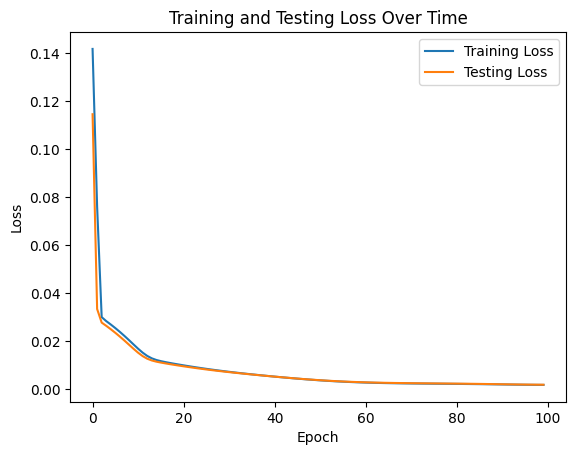

In [43]:
# Set the input sequence length to one week (168 hours)
input_seq_len = 24*7 # time steps
output = 1  # predict one time step into the future
# Initialize the encoder and decoder
model = Model(input_size=1, output_size=output, hidden_dim=128, n_layers=3) # 3 layers, 128 hidden nodes each
model = model.to(device)  # Move the model to the specified device
# Set the number of training epochs and learning rate
num_epochs = 100
learning_rate = 0.00001

# Get the data loaders
file_path = "data/bilan-electrique.csv"
train_loader, test_loader, scaler = preprocess_data(file_path, sequence_length=input_seq_len, output_seq_len=output, batch_size=32)

# Train the model
model = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

In [106]:
#save model to file
torch.save(model.state_dict(), 'model/model_{}.pth'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

# Show the prediction of our model

In [107]:
from typing import Tuple, List
def forecast(model: torch.nn.Module , df: pd.DataFrame , sequence_length : int , scaler , to_predict : int, device: torch.device) -> Tuple[List[float], List[float]]:
    """Forecast the next to_predict of consumption using the trained model and the last week of data.
    It is assumed that the model was trained with the same sequence_length.
    The predictions are done in a rolling manner, i.e. the first prediction is done using the last week of data, the second using the last week + the first prediction, etc.

    Args:
        model (torch.nn.Module): The trained model
        df (pandas.DataFrame): The dataframe containing the data
        sequence_length (int): The length of the input sequence used to predict the next value
        scaler (sklearn.preprocessing.MinMaxScaler): The scaler used to scale the data
        to_predict (int): The number of hours to predict
        device (torch.device): The device (CPU or GPU) to use for computation
    
    Returns:
        predicted (list): The predicted values
        real (list): The real values to predict
    """
    
    # Extract the last week data and scale it
    last_week = df['consommation_totale'].values[-(sequence_length+to_predict):].reshape(-1, 1)
    last_week_scaled = scaler.transform(last_week)
    model.eval()  # set the model to evaluation mode
    predicted = []  # list to store the predicted values
    real = []  # list to store the real values
    first_seq = last_week_scaled[:-to_predict]
    sequence = first_seq
    with torch.no_grad():
        # Start predicting the next week consumption hour by hour
        for i in range(to_predict):  # 24 hours * 7 days = 168 hours
            sequence = torch.FloatTensor(sequence).to(device)  # get the last sequence_length values and move to the device
            sequence = sequence.unsqueeze(0)  # add a batch dimension
            prediction = model(sequence)  # make a prediction
            predicted_value = prediction[0, -1].item()  # get the last value (last hour prediction)
            predicted.append(scaler.inverse_transform([[predicted_value]]))  # reverse the scaling and append the prediction to the list
            
            # Append the real value to the list
            try:
                real_value = df['consommation_totale'].values[i-(to_predict)]
                real.append(real_value)
            except IndexError:  # if we've stepped out of the dataset boundaries (means we're predicting the future values)
                real.append(None)
            
            # replace in sequence the first value with the predicted value
            sequence = sequence.squeeze(0).cpu()  # move the sequence back to CPU for numpy operations
            sequence = sequence[1:]
            sequence = torch.cat([sequence, torch.FloatTensor([[predicted_value]])], dim=0)
            
    # Flatten the predicted list to have 1D list
    predicted = [item[0][0] for item in predicted]
    
    return predicted, real


In [108]:
time_to_predict = 24*6
df = read_data(file_path)
predicted, real = forecast(model, df, input_seq_len, scaler, to_predict = time_to_predict)
print(len(predicted))
print(len(real))

(288, 1)
144
144


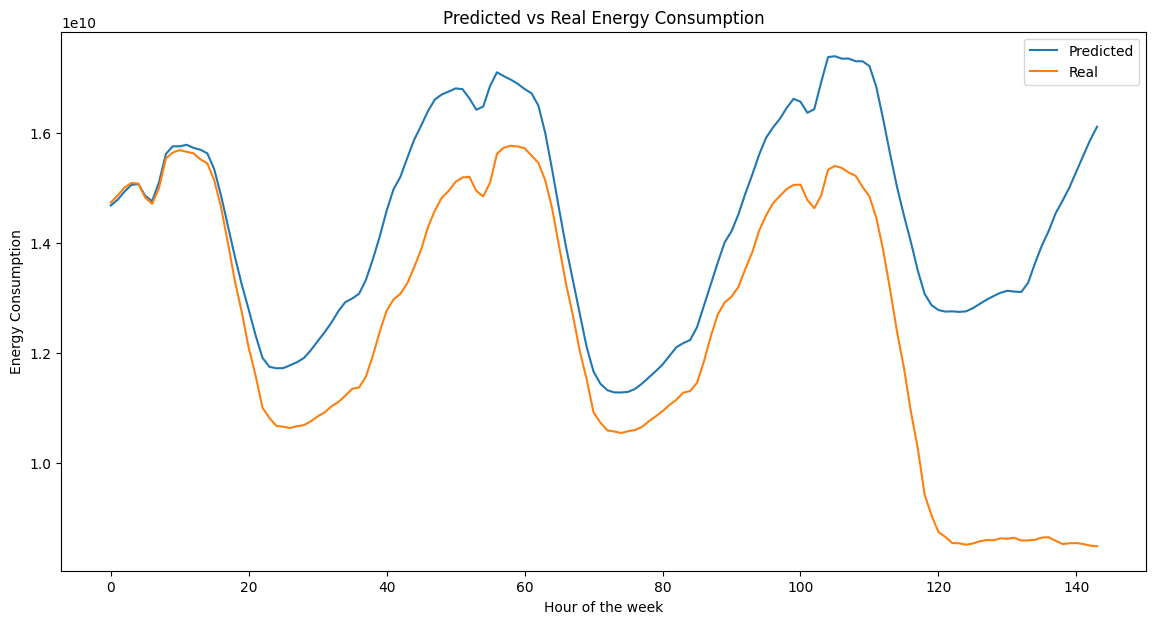

In [109]:
# Create the x axis. It represents the hour of the week from 0 to 168
x = list(range(0, time_to_predict))
# Plot the predicted and real values
plt.figure(figsize=(14, 7))
plt.plot(x, predicted, label='Predicted')
plt.plot(x, real, label='Real')
plt.title('Predicted vs Real Energy Consumption')
plt.xlabel('Hour of the week')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
